# Poisson Example 2D

Authors: Kidus Teshome, Cian Wilson

## A specific example

In this case we use a manufactured solution (that is, one that is not necessarily an example of a solution to a PDE representing a naturally occurring physical problem) where we take a known analytical solution $T(x,y)$ and substitute this into the original equation to find $h$, then use this as the right-hand side in our numerical test. We choose $T(x,y) = \exp\left(x+\tfrac{y}{2}\right)$, which is the solution to
\begin{equation}
-\nabla^2 T = -\tfrac{5}{4} \exp \left( x+\tfrac{y}{2} \right)
\end{equation}
Solving the Poisson equation numerically in a unit square, $\Omega=[0,1]\times[0,1]$, for the approximate solution $\tilde{T} \approx T$, we impose the boundary conditions
\begin{align}
  \tilde{T} &= \exp\left(x+\tfrac{y}{2}\right) && \text{on } \partial\Omega \text{ where } x=0 \text{ or } y=0 \\
  \nabla \tilde{T}\cdot \hat{\vec{n}} &= \exp\left(x + \tfrac{y}{2}\right) && \text{on } \partial\Omega \text{ where } x=1  \\
  \nabla \tilde{T}\cdot \hat{\vec{n}} &= \tfrac{1}{2}\exp\left(x + \tfrac{y}{2}\right) && \text{on } \partial\Omega \text{ where } y=1
 \end{align}
representing an essential Dirichlet condition on the value of $\tilde{T}$ and natural Neumann conditions on $\nabla\tilde{T}$.

## Implementation

This example was presented by [Wilson & van Keken, 2023](http://dx.doi.org/10.1186/s40645-023-00588-6) using FEniCS v2019.1.0 and [TerraFERMA](https://terraferma.github.io), a GUI-based model building framework that also uses FEniCS v2019.1.0.  Here we reproduce these results using the latest version of FEniCS, FEniCSx.

### Preamble

We start by loading all the modules we will require and initializing our plotting preferences through [pyvista](https://pyvista.org/).

In [1]:
from mpi4py import MPI
import dolfinx as df
from petsc4py import PETSc
import dolfinx.fem.petsc
import numpy as np
import ufl
import matplotlib.pyplot as pl
import sys, os
basedir = ''
if "__file__" in globals(): basedir = os.path.dirname(__file__)
sys.path.append(os.path.join(basedir, os.path.pardir, 'python'))
import utils
import pyvista as pv
if __name__ == "__main__" and "__file__" in globals():
    pv.OFF_SCREEN = True
import pathlib
if __name__ == "__main__":
    output_folder = pathlib.Path(os.path.join(basedir, "output"))
    output_folder.mkdir(exist_ok=True, parents=True)

### Solution

We then declare a python function `solve_poisson_2d` that contains a complete description of the discrete Poisson equation problem.

This function follows much the same flow as described in the introduction
1. we describe the unit square domain $\Omega = [0,1]\times[0,1]$ and discretize it into $2 \times$ `ne` $\times$ `ne` triangular elements or cells to make a `mesh`
2. we declare the **function space**, `V`, to use Lagrange polynomials of degree `p`
3. using this function space we declare trial, `T_a`, and test, `T_t`, functions
4. we define the Dirichlet boundary condition, `bc` at the boundaries where $x=0$ or $y=0$, setting the desired value there to the known exact solution
5. we define a finite element `Function`, `gN`, containing the values of $\nabla \tilde{T}$ on the Neumann boundaries where $x=1$ or $y=1$ (note that this will be used in the weak form rather than as a boundary condition object)
6. we define the right hand side forcing function $h$, `h`
7. we describe the **discrete weak forms**, `S` and `f`, that will be used to assemble the matrix $\mathbf{S}$ and vector $\mathbf{f}$
8. we solve the matrix problem using a linear algebra back-end and return the solution

For a more detailed description of solving the Poisson equation using FEniCSx, see [the FEniCSx tutorial](https://jsdokken.com/dolfinx-tutorial/chapter1/fundamentals.html).

In [2]:
import time
import contextlib
@contextlib.contextmanager
def record_time(suffix: str="", comm=MPI.COMM_WORLD):
    try:
        start_time = time.time()
        yield
    finally:
        print(suffix+f"({comm.rank}) {time.time() - start_time}")

In [3]:
def solve_poisson_2d(ne, p=1, petsc_options={"ksp_type": "preonly", \
                                             "pc_type": "lu",
                                             "pc_factor_mat_solver_type": "mumps"}):
    """
    A python function to solve a two-dimensional Poisson problem
    on a unit square domain.
    Parameters:
    * ne - number of elements in each dimension
    * p  - polynomial order of the solution function space
    """
    # Describe the domain (a unit square)
    # and also the tessellation of that domain into ne 
    # equally spaced squares in each dimension which are
    # subdivided into two triangular elements each
    with record_time("Generate mesh "):
        mesh = df.mesh.create_unit_square(MPI.COMM_WORLD, ne, ne)

    # Define the solution function space using Lagrange polynomials
    # of order p
    with record_time("Generate functionspace "):
        V = df.fem.functionspace(mesh, ("Lagrange", p))

    # Define the trial and test functions on the same function space (V)
    with record_time("Generate functions "):
        T_a = ufl.TrialFunction(V)
        T_t = ufl.TestFunction(V)


    with record_time("Generate Dirichlet bcs "):
        # Define the location of the boundary condition, x=0 and y=0
        def boundary(x):
            return np.logical_or(np.isclose(x[0], 0), np.isclose(x[1], 0))
        boundary_dofs = df.fem.locate_dofs_geometrical(V, boundary)
        # Specify the value and define a Dirichlet boundary condition (bc)
        gD = df.fem.Function(V)
        gD.interpolate(lambda x: np.exp(x[0] + x[1]/2.))
        bc = df.fem.dirichletbc(gD, boundary_dofs)


    with record_time("Generate Neumann bcs "):
        # Get the coordinates
        x = ufl.SpatialCoordinate(mesh)
        # Define the Neumann boundary condition function
        gN = ufl.as_vector((ufl.exp(x[0] + x[1]/2.), 0.5*ufl.exp(x[0] + x[1]/2.)))
        # Define the right hand side function, h
        h = -5./4.*ufl.exp(x[0] + x[1]/2.)


    with record_time("Generate forms "):
        # Get the unit vector normal to the facets
        n = ufl.FacetNormal(mesh)
        # Define the integral to be assembled into the stiffness matrix
        S = df.fem.form(ufl.inner(ufl.grad(T_t), ufl.grad(T_a))*ufl.dx)
        # Define the integral to be assembled into the forcing vector,
        # incorporating the Neumann boundary condition weakly
        f = df.fem.form(T_t*h*ufl.dx + T_t*ufl.inner(gN, n)*ufl.ds)


    with record_time("Assemble problem "):
        # # Compute the solution (given the boundary condition, bc)
        # problem = df.fem.petsc.LinearProblem(S, f, bcs=[bc], \
        #                                     petsc_options=petsc_options)
        # T_i = problem.solve()

        A = df.fem.petsc.assemble_matrix(S, bcs=[bc])
        A.assemble()
        b = df.fem.petsc.assemble_vector(f)
        df.fem.petsc.apply_lifting(b, [S], bcs=[[bc]])
        b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

        df.fem.petsc.set_bc(b, [bc])

    with record_time("Solve problem "):
        ksp = PETSc.KSP().create(MPI.COMM_WORLD)
        ksp.setOperators(A)
        ksp.setType("preonly")

        pc = ksp.getPC()
        pc.setType("lu")
        pc.setFactorSolverType("mumps")
        pc.setFactorSetUpSolverType()

        T_i = df.fem.Function(V)

        ksp.solve(b, T_i.x.petsc_vec)

    return T_i

We can now numerically solve the equations using, e.g., 4 elements and piecewise linear polynomials.

In [4]:
if __name__ == "__main__":
    ne = 4
    p = 1
    T_P1 = solve_poisson_2d(ne, p=p)
    T_P1.name = "T (P1)"

Generate mesh (0) 0.011517763137817383
Generate functionspace (0) 0.00482940673828125
Generate functions (0) 4.363059997558594e-05
Generate Dirichlet bcs (0) 0.0010106563568115234
Generate Neumann bcs (0) 0.00015878677368164062
Generate forms (0) 0.00276947021484375
Assemble problem (0) 0.006431102752685547
Solve problem (0) 0.004909038543701172


```{admonition} __main__
Note that this code block starts with `if __name__ == "__main__":` to prevent it from being run unless being run as a script or in a Jupyter notebook.  This prevents unecessary computations when this code is used as a python module.
```

And use some utility functions (see `../python/utils.py`) to plot it.

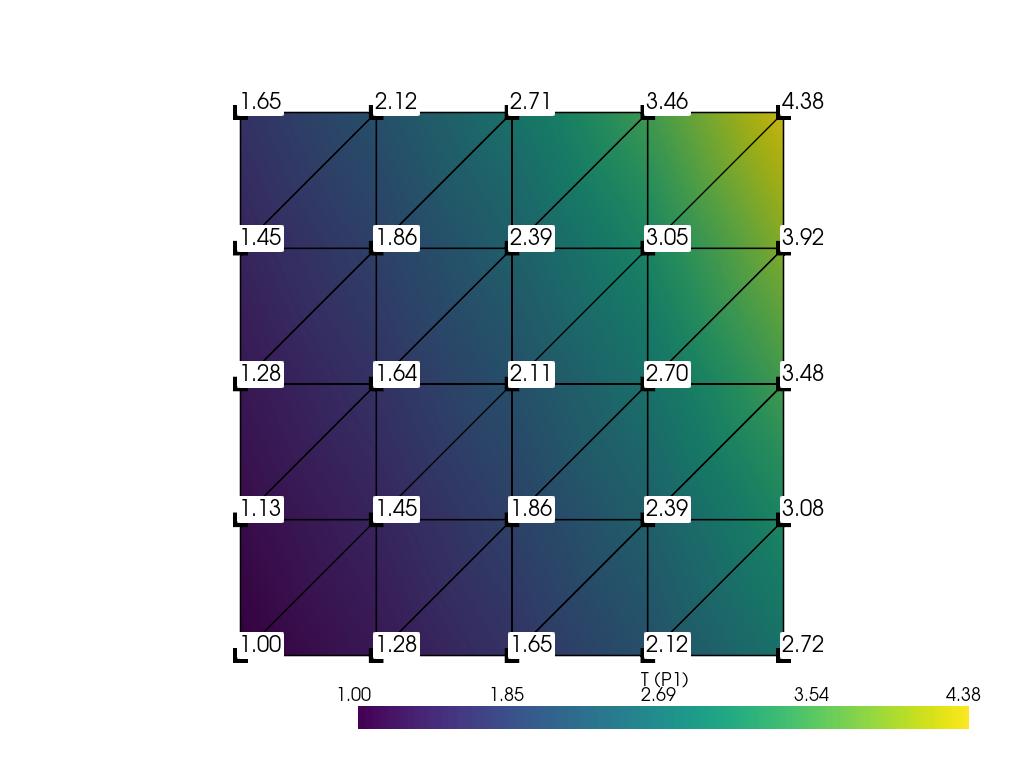

In [5]:
if __name__ == "__main__":
    # plot the solution as a colormap
    plotter_P1 = utils.plot_scalar(T_P1, gather=True)
    # plot the mesh
    utils.plot_mesh(T_P1.function_space.mesh, plotter=plotter_P1, gather=True, show_edges=True, style="wireframe", color='k', line_width=2)
    # plot the values of the solution at the nodal points 
    utils.plot_scalar_values(T_P1, plotter=plotter_P1, gather=True, point_size=15, font_size=22, shape_color='w', text_color='k', bold=False)
    # show the plot
    utils.plot_show(plotter_P1)
    # save the plot
    utils.plot_save(plotter_P1, output_folder / "2d_poisson_P1_solution.png")
    comm = T_P1.function_space.mesh.comm
    if comm.size > 1:
        # if we're running in parallel (e.g. from a script) then save an image per process as well
        plotter_P1_p = utils.plot_scalar(T_P1)
        utils.plot_mesh(T_P1.function_space.mesh, plotter=plotter_P1_p, show_edges=True, style="wireframe", color='k', line_width=2)
        utils.plot_scalar_values(T_P1, plotter=plotter_P1_p, point_size=15, font_size=22, shape_color='w', text_color='k', bold=False)
        utils.plot_save(plotter_P1_p, output_folder / "2d_poisson_P1_solution_p{:d}.png".format(comm.rank,))

Similarly, we can solve the equation using quadratic elements (`p=2`).

In [6]:
if __name__ == "__main__":
    ne = 4
    p = 2
    T_P2 = solve_poisson_2d(ne, p=p)
    T_P2.name = "T (P2)"

Generate mesh (0) 0.002239227294921875
Generate functionspace (0) 0.0021004676818847656
Generate functions (0) 3.2901763916015625e-05
Generate Dirichlet bcs (0) 0.0008914470672607422
Generate Neumann bcs (0) 0.0001430511474609375
Generate forms (0) 0.0019404888153076172
Assemble problem (0) 0.00142669677734375
Solve problem (0) 0.0014982223510742188


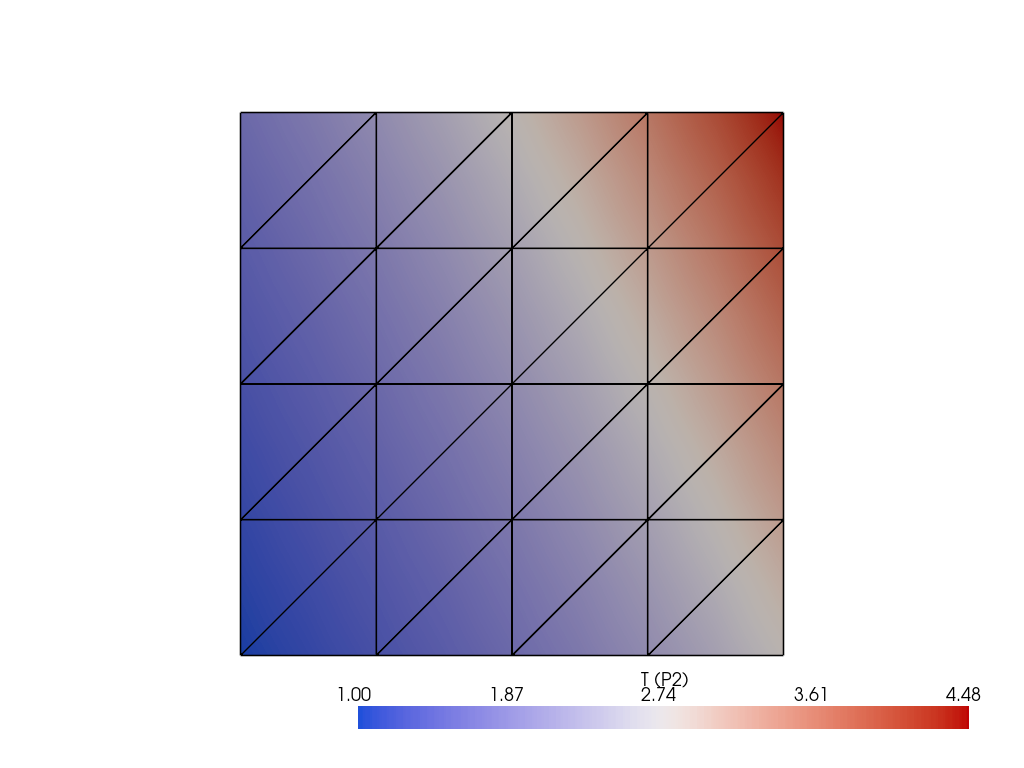

In [7]:
if __name__ == "__main__":
    # plot the solution as a colormap
    plotter_P2 = utils.plot_scalar(T_P2, gather=True, cmap='coolwarm')
    # plot the mesh
    utils.plot_mesh(T_P2.function_space.mesh, plotter=plotter_P2, gather=True, show_edges=True, style="wireframe", color='k', line_width=2)
    # plot the values of the solution at the nodal points 
    #utils.plot_scalar_values(T_P2, plotter=plotter_P2, gather=True, point_size=15, font_size=12, shape_color='w', text_color='k', bold=False)
    # show the plot
    utils.plot_show(plotter_P2)
    # save the plot
    utils.plot_save(plotter_P2, output_folder / "2d_poisson_P2_solution.png")
    comm = T_P2.function_space.mesh.comm
    if comm.size > 1:
        # if we're running in parallel (e.g. from a script) then save an image per process as well
        plotter_P2_p = utils.plot_scalar(T_P2, cmap='coolwarm')
        utils.plot_mesh(T_P2.function_space.mesh, plotter=plotter_P2_p, show_edges=True, style="wireframe", color='k', line_width=2)
        #utils.plot_scalar_values(T_P2, plotter=plotter_P2_p, point_size=15, font_size=12, shape_color='w', text_color='k', bold=False)
        utils.plot_save(plotter_P2_p, output_folder / "2d_poisson_P2_solution_p{:d}.png".format(comm.rank,))

## Themes and variations

Some suggested interactive tasks.

* Given that we know the exact solution to this problem is $T(x,y)$=$\exp\left(x+\tfrac{y}{2}\right)$ write a python function to evaluate the error in our numerical solution.
* Loop over a variety of `ne`s and `p`s and check that the numerical solution converges with an increasing number of degrees of freedom.

Note that, aside from the analytic solution being different, these tasks should be very similar to the 1D case in `notebooks/poisson_1d.ipynb`.

Finally,
* To try writing your own weak form, write an equation for the gradient of $\tilde{T}$, describe it using ufl, solve it, and plot the solution.

## Finish up

Convert this notebook to a python script (making sure to save first)

In [8]:
if __name__ == "__main__" and "__file__" not in globals():
    from ipylab import JupyterFrontEnd
    app = JupyterFrontEnd()
    app.commands.execute('docmanager:save')
    !jupyter nbconvert --NbConvertApp.export_format=script --ClearOutputPreprocessor.enabled=True poisson_2d.ipynb

[NbConvertApp] Converting notebook poisson_2d.ipynb to script
[NbConvertApp] Writing 11948 bytes to poisson_2d.py
